# Recycle Project

In [16]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import InputLayer, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D,MaxPooling2D
from keras.layers import BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

### Process and Verify Image Dataset Characteristics

In [17]:
### Define the path where our dataset is stored
dataset_path = r'C:\Users\smorasoto\OneDrive - Microsoft\Documents\MLandAI certi\RecycleProjectpart2\image250'

### Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

### Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

### Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
### ### Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
### ### Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
### ### Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
### ### Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
### Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

cardboard folder contains 250 images.
glass folder contains 250 images.
metal folder contains 250 images.
paper folder contains 250 images.
plastic folder contains 250 images.
trash folder contains 137 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


### Visualize Sample Images for Each Trash Category

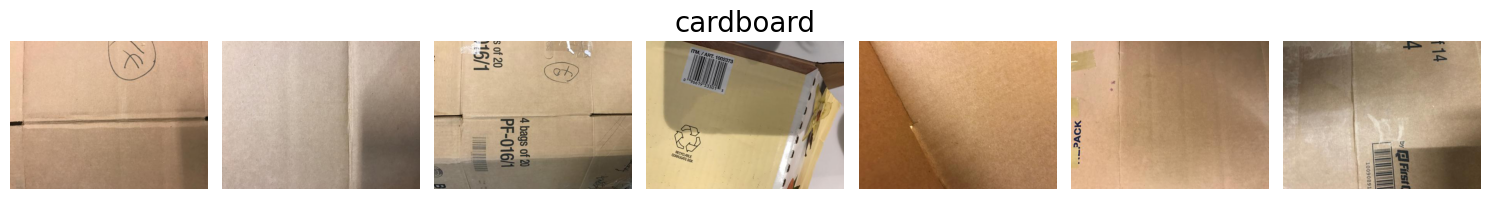

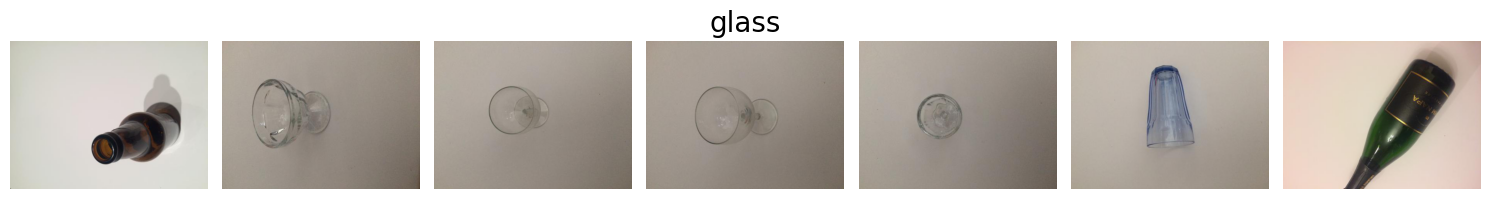

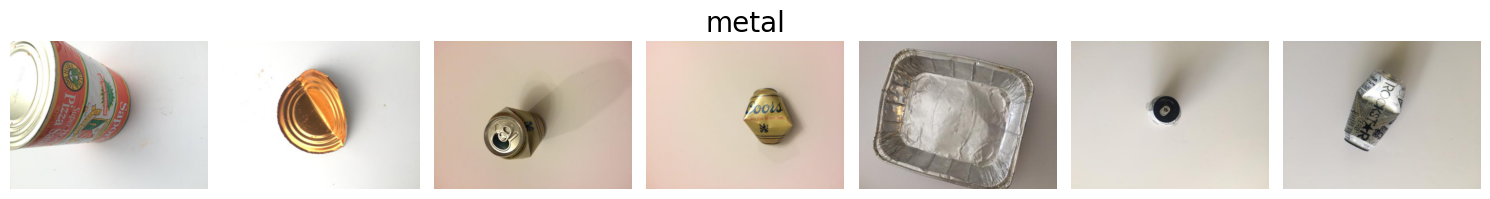

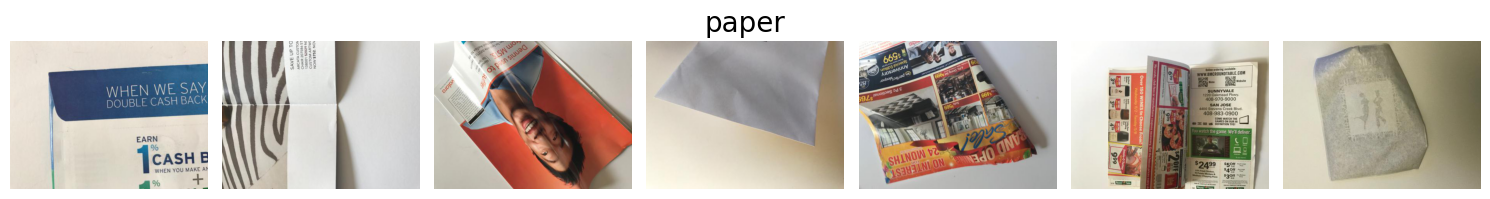

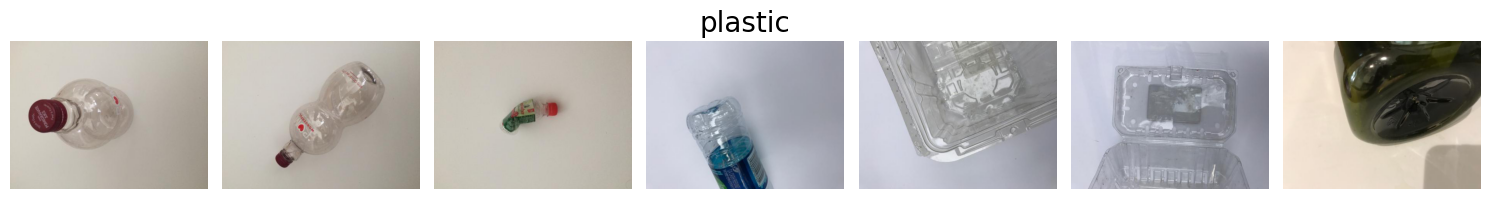

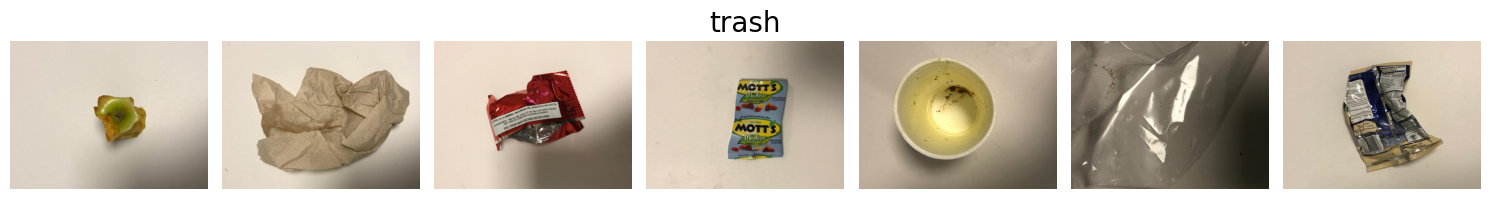

In [18]:
### Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
### ### Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
### ### Select the first 10 images
        image_files = image_files[:7]
        
### ### Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

### Prepare Image File Paths and Labels for Dataset

In [19]:
### Initialize an empty list to store image file paths and their respective labels
data = []

### Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
### ### Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

### Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

### Display the first few entries of the DataFrame
df.head()

,filepath,label
0,C:\Users\smorasoto\OneDrive - Microsoft\Docume...,cardboard
1,C:\Users\smorasoto\OneDrive - Microsoft\Docume...,cardboard
2,C:\Users\smorasoto\OneDrive - Microsoft\Docume...,cardboard
3,C:\Users\smorasoto\OneDrive - Microsoft\Docume...,cardboard
4,C:\Users\smorasoto\OneDrive - Microsoft\Docume...,cardboard


### Split Dataset into Training and Validation Sets with Stratification

In [20]:
### Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

### Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 1109
Number of images in the validation set: 278


### Configure Image Data Augmentation for Training and Validation

In [21]:
### Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
### ###widthshiftrange=0.15,             ### Randomly shift images horizontally by up to 15% of the width
### ###heightshiftrange=0.15,            ### Randomly shift images vertically by up to 15% of the height
### ###zoomrange=0.15,                    ### Randomly zoom in or out by up to 15%
### ###horizontalflip=True,               ### Randomly flip images horizontally
### ###verticalflip=True,                 ### Randomly flip images vertically
### ###shearrange=0.05,                   ### Apply slight shear transformations
### ###brightnessrange=[0.9, 1.1],        ### Vary brightness between 90% to 110% of original
### ###channelshiftrange=10,             ### Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    validation_split=0.2
)

### Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)

### Generate Training and Validation Data Batches

In [22]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),              # Resize all images to size of 384x384
    batch_size=64,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False,                        # Data is not shuffled; order retained from DataFrame
    subset='training'
)


### Generate validation batches from the validation dataframe
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),              # Resize all images to size of 384x384
    batch_size=64,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False,                        # Data is not shuffled; order retained from DataFrame
    subset='validation'
)

Found 1110 images belonging to 6 classes.
Found 277 images belonging to 6 classes.


### Load Pretrained Models and Configure Feature Extractor

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, Lambda
from tensorflow.keras.models import Model
### inlay = Input((384,384,3))
### vgg = VGG16(includetop=False, weights='imagenet', inputshape=(224,224,3))
res = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in res.layers:
    layer.trainable=False

### Build and Summarize the Model

In [24]:
x = Flatten()(res.output)
prediction = Dense(6,activation='softmax')(x)
model_1 = Model(inputs=res.input, outputs=prediction)
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,933,766 (224.81 MB)

 Trainable params: 602,118 (2.30 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

### Compile Model

In [25]:
from keras.metrics import top_k_categorical_accuracy
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
callbacks = EarlyStopping(patience = 5, monitor='val_accuracy', mode='max')
### reducelr = ReduceLROnPlateau(monitor='valacc', factor=0.2, patience=10, minlr=0.00001)

### modelcheckpointcallback = tf.keras.callbacks.ModelCheckpoint(
### filepath='vggmodel.keras',
### saveweightsonly=False,
### monitor='loss',
### savebestonly=True,
### mode='max')

### runopts = tf.RunOptions(reporttensorallocationsuponoom = True)

model_1.compile(optimizer = Adam(learning_rate=0.0001), 
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

### Train the Model and Monitor Performance

In [26]:
history=model_1.fit(train_generator, 
                           steps_per_epoch = train_df.shape[0], #train_df.shape[0]//batch_size,
                           validation_data = val_generator, 
                           validation_steps = val_df.shape[0], #valid_df.shape[0]//batch_size,
                              epochs = 30
                            )

Epoch 1/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 301s 203ms/step - accuracy: 0.1662 - loss: 6.0380 - val_accuracy: 0.4007 - val_loss: 2.7674
Epoch 2/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 201s 173ms/step - accuracy: 0.4146 - loss: 3.2307 - val_accuracy: 0.6679 - val_loss: 1.2938
Epoch 3/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 193s 171ms/step - accuracy: 0.6830 - loss: 1.3847 - val_accuracy: 0.6931 - val_loss: 1.1929
Epoch 4/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 194s 166ms/step - accuracy: 0.7427 - loss: 0.9140 - val_accuracy: 0.7184 - val_loss: 0.9919
Epoch 5/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 183s 156ms/step - accuracy: 0.7883 - loss: 0.7485 - val_accuracy: 0.7509 - val_loss: 0.8734
Epoch 6/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 190s 163ms/step - accuracy: 0.7842 - loss: 0.6813 - val_accuracy: 0.7329 - val_loss: 0.8947
Epoch 7/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 199s 170ms/step - accuracy: 0.8578 - loss: 0.4478 - val_accuracy: 0.7365 - val_loss: 0.8490
Epoch 8/30
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 200s 171ms/step - ac

### Save the Trained Model in Multiple Formats

In [27]:
model_1.save('recyclemodeldrafgood3v2.keras')
model_1.save('recyclemodeldrafgood3v2.h5')


### Evaluate Model

In [28]:
### Evaluate the model
results = model_1.evaluate(val_generator)
print(f"Loss: {results[0]}, Accuracy: {results[1]}")

### Check the number of loaded samples
print(f"Número de muestras en entrenamiento: {train_generator.samples}")
print(f"Número de muestras en validación: {val_generator.samples}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.8467 - loss: 0.4946
Loss: 0.6548987030982971, Accuracy: 0.8050541281700134
Número de muestras en entrenamiento: 1110
Número de muestras en validación: 277


#### Evaluate Model Performance and Generate Detailed Metrics

5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.8695 - loss: 0.4261
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 12s/step
              precision    recall  f1-score   support

   cardboard       0.94      0.98      0.96        50
       glass       0.79      0.82      0.80        50
       metal       0.84      0.82      0.83        50
       paper       0.86      0.88      0.87        50
     plastic       0.77      0.80      0.78        50
       trash       0.76      0.59      0.67        27

    accuracy                           0.83       277
   macro avg       0.83      0.82      0.82       277
weighted avg       0.83      0.83      0.83       277



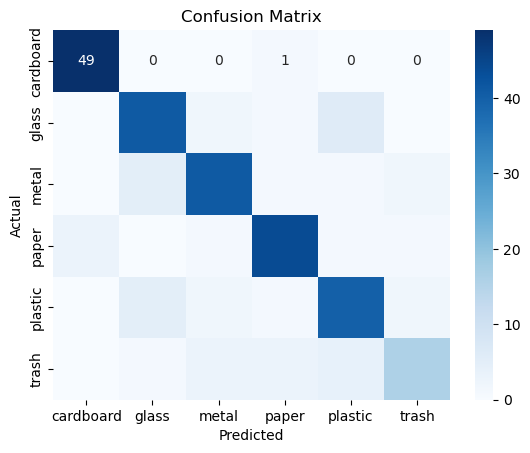

In [29]:

### Evaluate the model on a test set and generate additional metrics
from sklearn.metrics import classification_report, confusion_matrix

### Evaluate on the validation set
val_loss, val_accuracy = model_1.evaluate(val_generator, verbose=1)

### Generate predictions for the validation set
y_pred = model_1.predict(val_generator)
y_true = val_generator.classes

### Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

### Print a classification report
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

### Display a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Plotting Training results

In [30]:
def plot_history(history):
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    plt.figure(2)
    epochs=range(1,len(history.history[acc_list[0]]) + 1)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

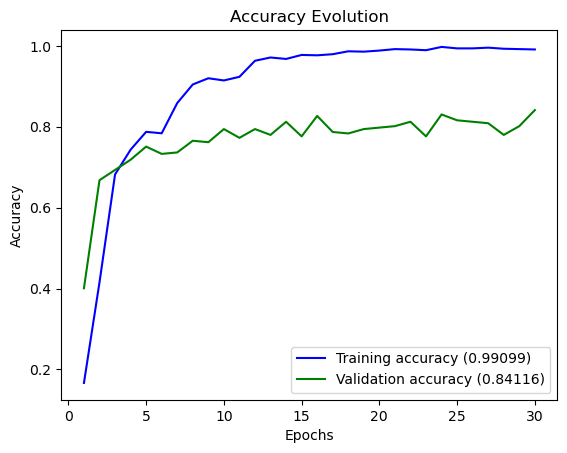

In [31]:
plot_history(history)

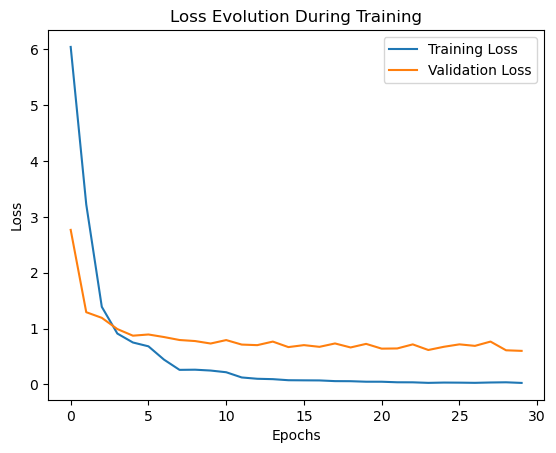

In [32]:
### Graficar la evolución de la pérdida
import matplotlib.pyplot as plt

### Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Making Predictions
Check the model's predicctions on a few images

In [33]:
import pandas as pd

### Compare predictions with true labels
correct_samples = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred_classes,
    'Filename': val_generator.filenames  # Corresponding file names
})

### Filter only the correctly classified samples
correct_samples = correct_samples[correct_samples['Actual'] == correct_samples['Predicted']]
print(f"Total correctly classified samples: {len(correct_samples)}")

### Display the first rows of the correctly classified samples
print(correct_samples.head())

Total correctly classified samples: 231
   Actual  Predicted                     Filename
0       0          0  cardboard\cardboard_001.jpg
1       0          0  cardboard\cardboard_002.jpg
2       0          0  cardboard\cardboard_003.jpg
3       0          0  cardboard\cardboard_004.jpg
4       0          0  cardboard\cardboard_005.jpg



Showing correctly classified images for category: 0


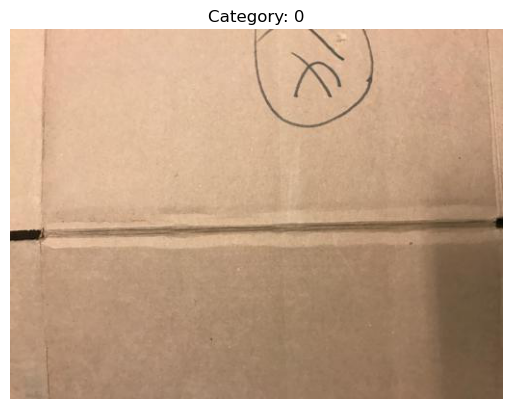


Showing correctly classified images for category: 1


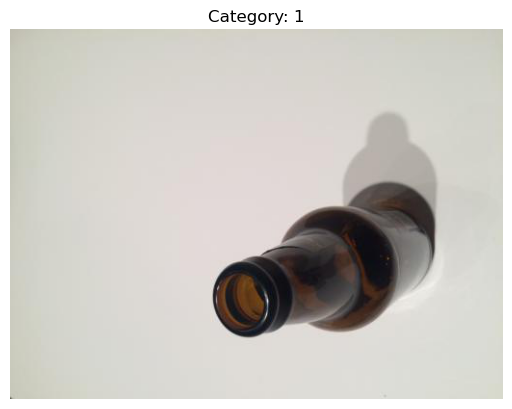


Showing correctly classified images for category: 2


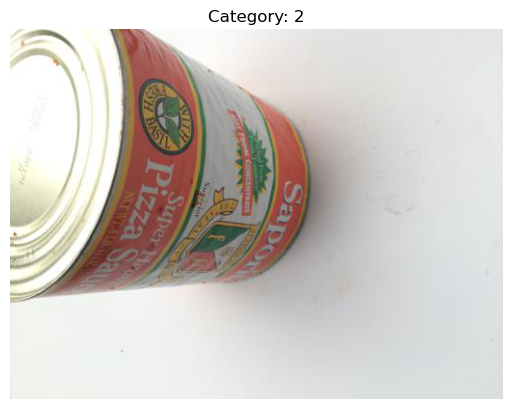


Showing correctly classified images for category: 3


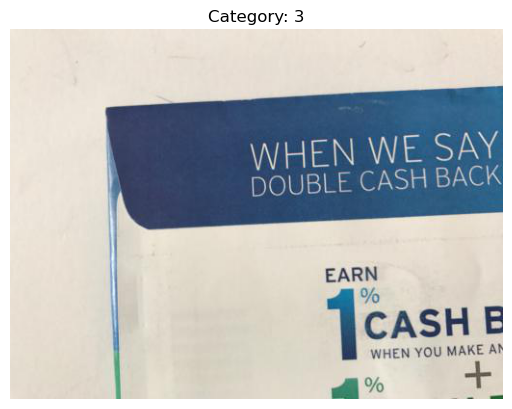


Showing correctly classified images for category: 4


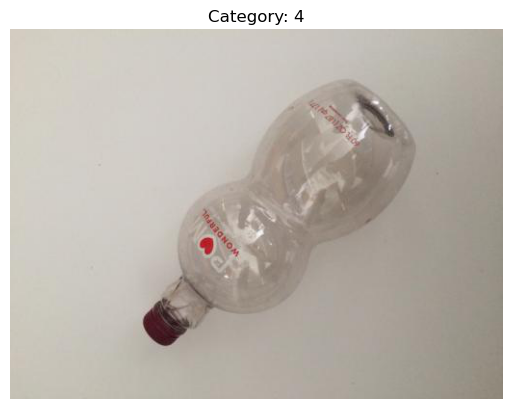


Showing correctly classified images for category: 5


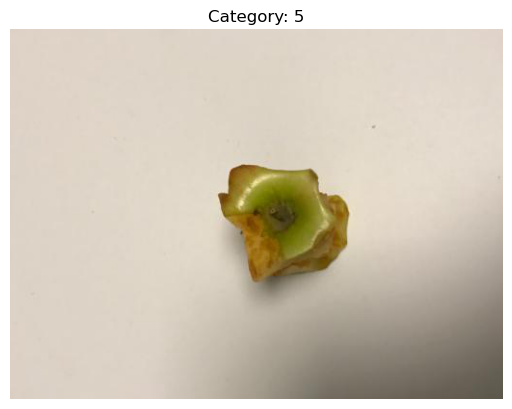

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Get the unique categories of the correctly classified samples
unique_classes = correct_samples['Actual'].unique()

# Iterate over each category to display correctly classified images
for class_label in unique_classes:
    print(f"\nShowing correctly classified images for category: {class_label}")
    
    # Filter correctly classified images for the current category
    class_samples = correct_samples[correct_samples['Actual'] == class_label]
    
    # Show up to 3 images from this category
    for i in range(min(1, len(class_samples))):  # Maximum 3 images per category
        img_path = os.path.join(val_generator.directory, class_samples.iloc[i]['Filename'])
        img = mpimg.imread(img_path)

        plt.imshow(img)
        plt.title(f"Category: {class_label}")
        plt.axis('off')
        plt.show()

In [35]:
import pandas as pd

# Compare predictions with true labels
errors = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred_classes,
    'Filename': val_generator.filenames  # Corresponding file names
})

# Filter only the misclassified samples
errors = errors[errors['Actual'] != errors['Predicted']]
print(f"Total errors: {len(errors)}")

Total errors: 46


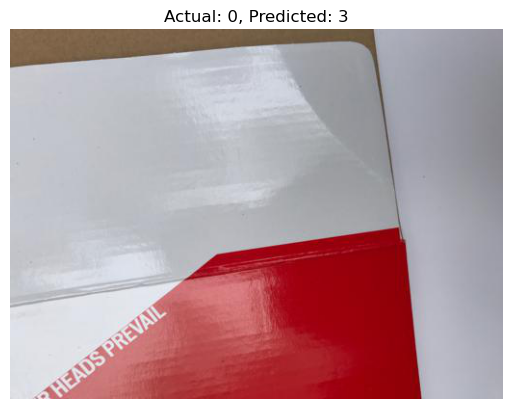

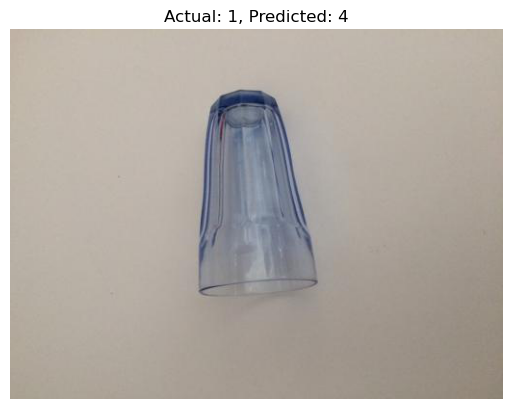

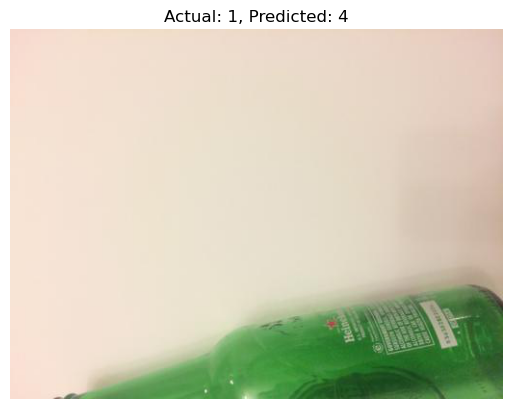

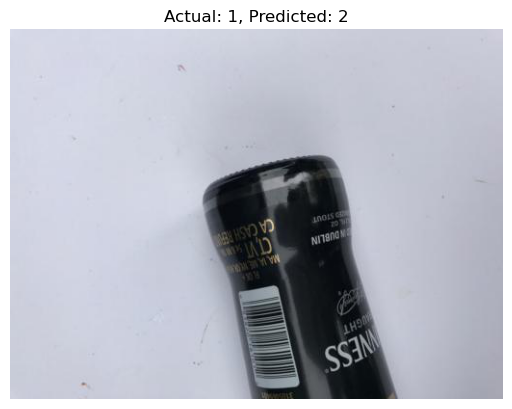

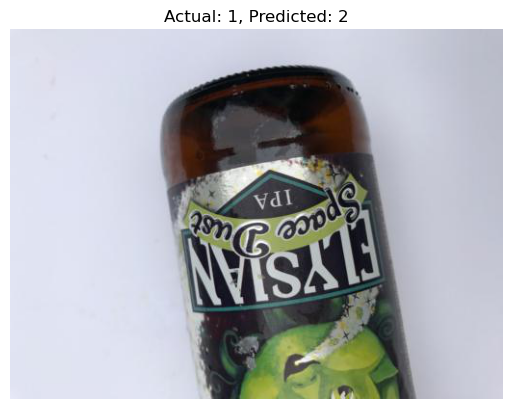

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display examples of errors
for i in range(min(5, len(errors))):  # Show up to 5 errors
    img_path = os.path.join(val_generator.directory, errors.iloc[i]['Filename'])
    img = mpimg.imread(img_path)
    
    plt.imshow(img)
    plt.title(f"Actual: {errors.iloc[i]['Actual']}, Predicted: {errors.iloc[i]['Predicted']}")
    plt.axis('off')
    plt.show()